# Best available pixel composite

In this notebook a monthly composite image is created based on the Best Available Pixel (BAP) method in OpenEO. This is a scientifically sound method of generating composites, which minimizes the mixing of pixels from different observations. Also for each pixel, all bands will be taken from a single observation. As a result, the spectral signature in the composite is observed rather than being a combination of multiple observations.

We refer to the scientific references for a full discussion of this method, but can generally recommend it both for its correctness and performance. We do still observe some residual cloud (shadow) in certain cases, which can be attributed to the quality of the SCL band. 

The BAP score is a weighted average of three (four) scores:

- **Distance-to-Cloud Score**: Pixels that are clouds are given score 0. Pixels that are more than 150 pixels - calculated with the Manhattan distance measure, assuming a resolution of 20m - away from a cloud pixel are given score 1. The pixels in between are given a score versus distance-to-cloud that follows a Gaussian shape.
- **Coverage Score**: Per date, the percentage of all pixels that are classified as a cloud over the entire spatial extent is calculated. The Coverage Score is then equal to 1 - the cloud percentage.
- **Date Score**: In order to favor pixels that are observed in the middle of a month, a date score is calculated, which follows a Gaussian shape. I.e. the largest scores are given for days in the middle of the month, the lowest scores are given for days at the beginning and end of the month. 

The final BAP score is a weighted average of the three aforementioned scores. The weights are 1, 0.5 and 0.8 for the Distance-to-Cloud, Coverage and Date Score respectively. 

The current implementation and the various parameters are still subject to change, so please do evaluate the correctness when using this method in your project. 

### References 

The approach described here was originally applied to Landsat, and adapted here for Sentinel-2. 

#### BAP composites assessment

Francini, S., Hermosilla, T., Coops, N. C., Wulder, M. A., White, J. C., & Chirici, G. (2023). An assessment approach for pixel-based image composites. ISPRS Journal of Photogrammetry and Remote Sensing, 202, 1–12, [doi:10.1016/j.isprsjprs.2023.06.002](https://doi.org/10.1016/j.isprsjprs.2023.06.002)

#### BAP process background:

White, J.C.; Wulder, M.A.; Hobart, G.W.; Luther, J.E.; Hermosilla, T.; Griffiths, P.; Coops, N.C.; Hall, R.J.; Hostert, P.; Dyk, A.; et al. Pixel-based image compositing for large-area dense time series applications and science. Can. J. Remote Sens. 2014, 40, 192–212, [doi:10.1080/07038992.2014.945827](https://doi.org/10.1080/07038992.2014.945827).


## Loading Sentinel-2 scene classification

The score is calculated based on the 'SCL' band only. This is very efficient because it's a lower resolution (20m) band, which is relatively quick to read.
All other bands are read based on the score, which allows openEO to avoid loading data that is not used in the composite.

First a sample period and region are defined. It is necessary to specify your region of interest as a Polygon.

In [1]:
import geopandas as gpd

gdf = gpd.read_file('test_area.geojson')
gdf = gdf.to_crs(epsg=4326)
area = eval(gdf.to_json())

In [2]:
temporal_extent = ["2022-07-01", "2022-07-31"]
max_cloud_cover = 70
spatial_resolution = 20

In [3]:
import openeo
import numpy as np

from openeo.processes import if_, is_nan

from utils_BAP import (calculate_cloud_mask, calculate_cloud_coverage_score,
                           calculate_date_score, calculate_distance_to_cloud_score,
                           calculate_distance_to_cloud_score, aggregate_BAP_scores,
                           create_rank_mask)

In [4]:
c=openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


Load in the SCL band from Sentinel-2 which will be used to calculate all cloud-related scores.

In [5]:
scl = c.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=temporal_extent,
    bands=["SCL"],
    max_cloud_cover=max_cloud_cover
).resample_spatial(spatial_resolution).filter_spatial(area)

scl = scl.apply(lambda x: if_(is_nan(x), 0, x))

Create a binary cloud mask, which gives 1 if a pixel is classified as cloud by SCL, an 0 otherwise.

In [6]:
cloud_mask =  calculate_cloud_mask(scl)

## Coverage score

First of all, the coverage score is calculated, which is equal to 1 - the percentage of pixels in the spatial_extent that are classified as cloud in SCL.

- A polygon is created that is slighty larger than the original spatial_extent
- The cloud coverage percentage is calculated by taking the average of the cloud binary (defined above), by using the `aggregate_spatial` process
- Since the `aggregate_spatial` process results in vectordata, the data is rasterized again to the original dimensions, using the (experimental) `vector_to_raster` process
- The coverage score is then equal to 1 - the cloud coverage percentage. I.e. a smaller cloud coverage percentage indicates a larger score

In [7]:
coverage_score = calculate_cloud_coverage_score(cloud_mask, area, scl)

## Date Score

Both the date and distance-to-cloud score are calculated via a UDF.

In [8]:
date_score = calculate_date_score(scl)

/home/vverelst/anaconda3/envs/openeo-app/lib/python3.9/site-packages/openeo/api/process.py:22: UserWarning: Parameter without description: using name as description.
  warnings.warn("Parameter without description: using name as description.")


## Distance to Cloud Score

Finally, the Distance to Cloud Score is calculated by applying a Gaussian kernel to the binary.
The kernel size, defined below, indicates the maximum distance from a cloud, above which a pixel is automatically assigned score 1. In case of a kernel size of 151, the maximum distance is 150 pixels. The kernel size is 151 for a resolution of 20m and will be rescaled accordingly.

In [9]:
dtc_score = calculate_distance_to_cloud_score(cloud_mask, spatial_resolution)

## Aggregating Scores

Then, the scores are aggregated together, by using a weighted average. As for now the coverage score is excluded. To make sure that pixels which contain no data (SCL score 0) are not selected, they are explicitly masked out of the final score. B01 score is excluded.

In [10]:
weights = [1, 0.8, 0.5]
score = aggregate_BAP_scores(dtc_score, date_score, coverage_score, weights)
score = score.mask(scl.band("SCL") == 0)

## Masking and Compositing

Next, a mask is created. This serves to mask every pixel, except the one with the highest score, for each month.

In [11]:
rank_mask = create_rank_mask(score)

Next, some bands of interest from Sentinel-2 are loaded. They are then masked by the BAP mask constructed above. Then they are aggregated per month, to obtain a composite image per month. By using the "first" process as an aggregator, the situation where there are potentially more than one days in a month selected by the algorithm is immediately handled.

In [12]:
rgb_bands = c.load_collection(
    "SENTINEL2_L2A",
    temporal_extent = temporal_extent,
    bands = ["B02", "B03","B04"],
    max_cloud_cover=max_cloud_cover
).filter_spatial(area)

composite = rgb_bands.mask(rank_mask).mask(cloud_mask).aggregate_temporal_period("month","first")

Next, the final results are downloaded and a composite image for the month of June is shown as an example.

In [13]:
job = composite.execute_batch(
    title="BAP Composite",
    out_format="netcdf"
)
results = job.get_results()
results.download_files('./results/')

0:00:00 Job 'j-24041209f0e64b119b20e266cb049c51': send 'start'
0:00:13 Job 'j-24041209f0e64b119b20e266cb049c51': running (progress N/A)
0:00:18 Job 'j-24041209f0e64b119b20e266cb049c51': running (progress N/A)
0:00:25 Job 'j-24041209f0e64b119b20e266cb049c51': running (progress N/A)
0:00:34 Job 'j-24041209f0e64b119b20e266cb049c51': running (progress N/A)
0:00:44 Job 'j-24041209f0e64b119b20e266cb049c51': running (progress N/A)
0:00:57 Job 'j-24041209f0e64b119b20e266cb049c51': running (progress N/A)
0:01:13 Job 'j-24041209f0e64b119b20e266cb049c51': running (progress N/A)
0:01:33 Job 'j-24041209f0e64b119b20e266cb049c51': running (progress N/A)
0:02:00 Job 'j-24041209f0e64b119b20e266cb049c51': running (progress N/A)
0:02:31 Job 'j-24041209f0e64b119b20e266cb049c51': finished (progress N/A)


[PosixPath('results/openEO.nc'), PosixPath('results/job-results.json')]

In [14]:
import xarray as xr
composite_ds = xr.open_dataset('./results/openEO.nc')

In [15]:
import numpy as np
rgb_array=composite_ds.to_array(dim="bands").sel(bands=["B04","B03","B02"]).astype(np.float32)/10000

/home/vverelst/anaconda3/envs/openeo-app/lib/python3.9/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


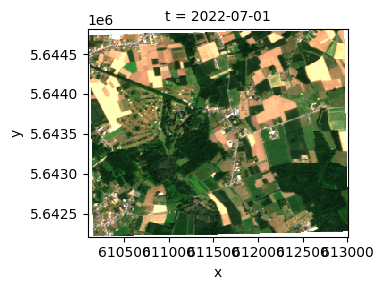

In [16]:
xr.plot.imshow(rgb_array,vmin=0,vmax=0.18,rgb="bands",col='t',col_wrap=2)